In [1]:
import os
import copy
import glob 
import json
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logging
sns.set() # clear whole style
%matplotlib inline

In [2]:
def make_col_readable(col_data, raw_key):
    """Make single column data readable."""
    k,m,g = 1024, 1024*1024, 1024*1024*1024
    
    col_mean = col_data.mean()
    
    if g <= col_mean:
        new_col = col_data / g
        new_key = "{}({})".format(raw_key, "G")
    
    if m <= col_mean < g:
        new_col = col_data / m
        new_key = "{}({})".format(raw_key, "M")
        
    elif k <= col_mean < m:
        new_col = col_data / k
        new_key = "{}({})".format(raw_key, "K")
    else:
        new_col, new_key = None, None
    return new_col, new_key 

def make_human_readable(data, keys):
    """Make a pandas data readable."""
    updated_map = dict()
    if not isinstance(keys, list):
        keys = [keys]
    for k in keys:
        col_data = data[k]
        updated_val, updated_key = make_col_readable(col_data, k)
        if not updated_key:  # 
            continue 
            
        # add new column
        data[updated_key] = updated_val
        updated_map.update({k: updated_key})
    
    return data, updated_map


METRIC_MAP = {
    "Classification": "accuarcy",
    "Super-Resolution": {"psnr", "ssim"},  # and 
    "Segmentation": "mIOU",
    "Detection": {"F1 score",  "LAMR"},  # or 
    "Click-Through Rate Prediction": "AUC",
}

PARAMS_SET = set(["model_size", "metric", "params", "flops", "Inference Time"])

def get_params_set(case_type, default_params, metric_map):
    """Get params set."""
    ret_params = copy.deepcopy(default_params)
    if "metric" in default_params:
        ret_params.remove("metric")
    metric_keys = metric_map.get(case_type)
    if not metric_keys:
        raise KeyError("not found case: {} in map: {}.".format(case_type, metric_map))
    elif isinstance(metric_keys, str):
        ret_params.add(metric_keys)
    elif isinstance(metric_keys, set):
        ret_params |= metric_keys
    else:
        raise ValueError("unkown value: {}".format(metric_keys))
        
    return ret_params

def test_get_params():
    detec_target = {'params', 'F1 score', 'model_size', 'Inference Time', 'flops', 'LAMR'}
    assert get_params_set("Detection", PARAMS_SET, METRIC_MAP) == detec_target
    
    classif_target = {'params', 'accuarcy', 'model_size', 'Inference Time', 'flops'}
    assert get_params_set("Classification", PARAMS_SET, METRIC_MAP) == classif_target
    print("check passed!")
    
if __name__ == "__main__":
    test_get_params()

check passed!


In [3]:
def _get_json_val(json_file):
    """Get json value."""
    with open(json_file, "r") as json_obj:
        single_val = json.load(json_obj)
    return single_val

def gather_metrics_from_dir(dir_path, case_type):
    """Collect the results under path."""
    json_files = glob.glob(os.path.join(dir_path, "*.json"))
    need_keys = get_params_set(case_type, PARAMS_SET, METRIC_MAP) 
    # print("json_files: ",json_files)
    ret_val_total = list()
    
    # try first json with keys check
    single_val = _get_json_val(json_files[0])
    unused_key = set([_k for _k in need_keys if _k not in single_val])
    need_keys -= unused_key
        
    # move set to list, own to order
    need_keys = list(need_keys)
    for _json_file in json_files:
        json_value = _get_json_val(_json_file)
        single_val = list([float(json_value[k]) for k in need_keys])
        
        # add json_file_name, consider the type between json file and data 
        single_val.append(_json_file)
        ret_val_total.append(single_val)
        
    ret_np = np.array(ret_val_total)
    
    ret_pd = pd.DataFrame(ret_np, columns=[*need_keys, "json_name"])
    ret_pd[need_keys] = ret_pd[need_keys].apply(pd.to_numeric)
    ret_pd.sort_values("model_size", inplace=True)
    return ret_pd

In [15]:
def plot_pruning_case(pdf, x_label, y_label, to_png_file="defaut.png", dpi=300):
    sns.set()
    sns.set(rc={"figure.figsize": (6.4, 3.6), "figure.dpi": 300})
    # sns.set_style("white")
    # sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth":0.5})
    sns.set_style("dark")

    fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(6.4,3.6))
    fig.subplots_adjust(hspace=0.1, wspace=0.25)
    plt.ticklabel_format(style='plain', axis='y')

    for count, (x, y, ax) in enumerate(zip(x_label, y_label, axes.reshape(-1))):  
        ax= sns.scatterplot(x=x, y=y,data=pdf,ax=ax)
        ax.set_xlabel(x,fontsize=6)
        ax.set_ylabel(y,fontsize=6)

        ax.tick_params(axis='y',labelsize=4, rotation=0)
        ax.tick_params(axis='x',labelsize=4, rotation=45)
        # ax.ticklabel_format(style='plain', axis='y',useOffset=False)

        if count < 2:
            ax.set(xlabel=None)
            ax.set(xticklabels=[])

    fig.savefig(to_png_file, dpi=dpi, bbox_inches='tight')
    return to_png_file

# Parameter description

- model_size  (y)  for y axis	
- accuracy	 (y)  metric types，support defined by user
- flops	(y) 
- params (y)    	
- latency_batch 	(y)   batch = (1, 32), batch 32 defautl
- latency_batch(1)      # use `Inference Time = latency_batch/batch`   
- latency_batch(32)


### Collect the json file under special path

**Input**
- dir_path: Directory to read json file
- case_type: case to analysis, choose from the keys of METRIC_MAP

**Output**：
- pandas.DataFrame

In [10]:
# example data typo, accuracy  , not accuarcy!!
ret_data = gather_metrics_from_dir(dir_path="./raw_metric1014",case_type="Classification")
ret_data

,Inference Time,accuarcy,model_size,flops,params,json_name
0,51.28,95.923477,7.72,469.0,1.878,./raw_metric1014/performance_104.json
4,69.00,96.584535,8.45,548.0,2.173,./raw_metric1014/performance_48.json
3,71.62,96.744791,9.32,620.0,2.389,./raw_metric1014/performance_69.json
1,82.72,97.055288,10.50,729.0,2.701,./raw_metric1014/performance_42.json
2,88.98,97.245592,11.30,786.0,2.884,./raw_metric1014/performance_52.json


In [6]:
type(ret_data["Inference Time"][1])

numpy.float64

### Check single json file

In [7]:
with open('./raw_metric1014/performance_104.json', "r") as f:
    v = json.load(f)
v

{'model_size': 7.72,
 'accuarcy': 95.923477,
 'params': 1.878,
 'flops': 469,
 'Inference Time': 51.28}

### Show the Pruning case

Input：
- data with pandas.DataFrame
- four label of x axis
- for label of y axis
- the name of image file to save

'./default_purning.png'

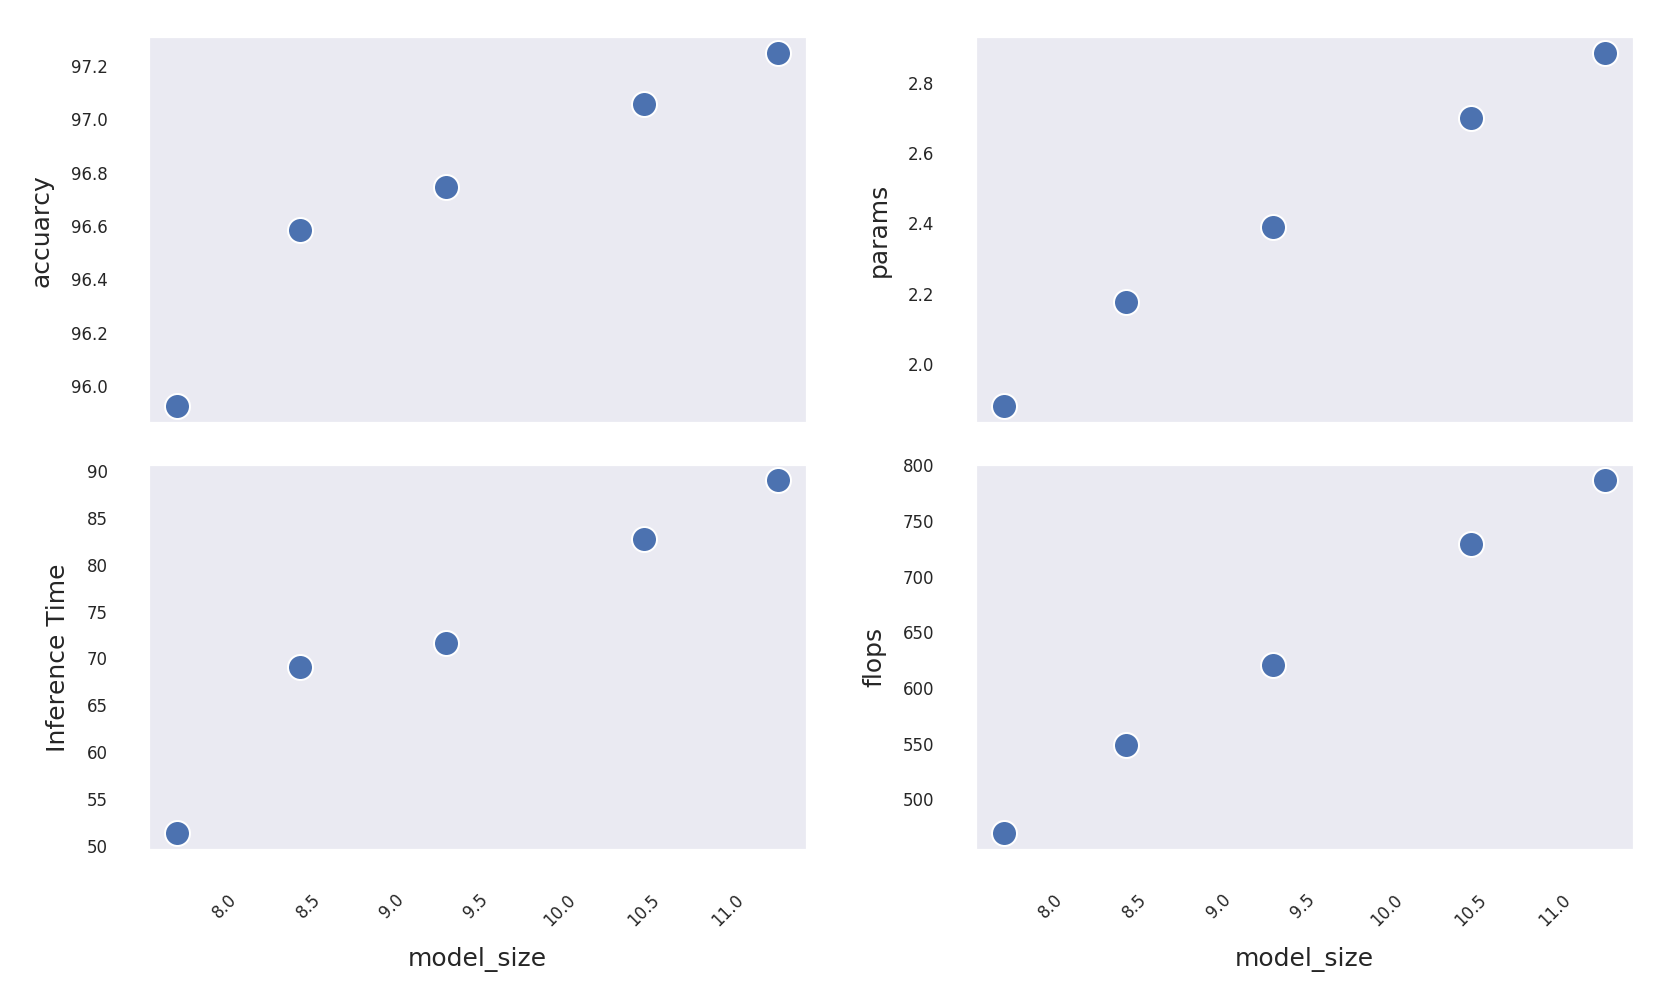

In [16]:
plot_pruning_case(ret_data, x_label=["model_size"]*4,
                  y_label=["accuarcy", "params", "Inference Time", "flops"], 
                  to_png_file="./default_purning.png", dpi=100)  # json key error

Index(['index', 'model_size', 'accuracy', 'latency_per_input', 'flops',
       'params', 'latency_sum', 'input_num', 'model_file'],
      dtype='object')
{'flops': 'flops(M)', 'model_size': 'model_size(K)', 'params': 'params(K)', 'input_num': 'input_num(K)'}


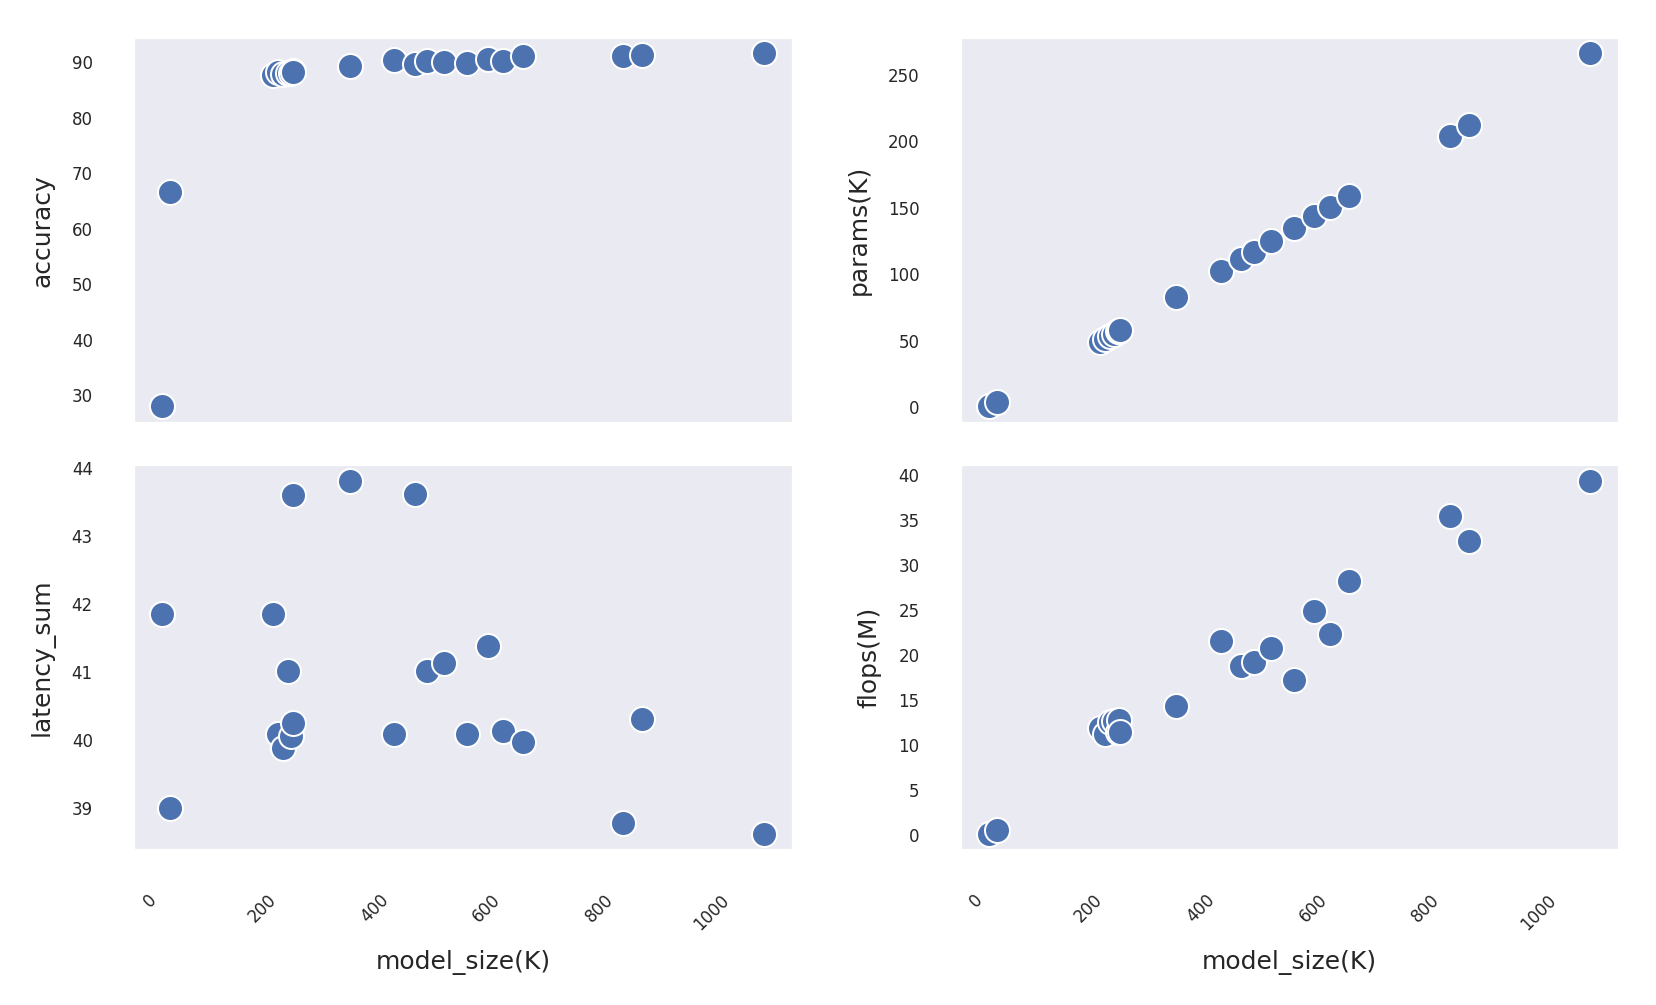

In [17]:
def plot_from_csv_summarize(csv_file, to_png_file="./default_summarize.png", dpi=300):
    """Plot pruning png with csv_summarize file."""
    pdf = pd.read_csv(csv_file)
    print(pdf.keys())
    
    pdf_readable, up_map = make_human_readable(pdf, ["flops", "model_size", "params", "input_num"])
    print(up_map)
    # print(pdf_readable)

    plot_pruning_case(pdf_readable, x_label=["model_size(K)"]*4, 
                      y_label=["accuracy", "params(K)", "latency_sum", "flops(M)"], 
                      to_png_file=to_png_file, dpi=dpi)
    
plot_from_csv_summarize(csv_file="./resnet20_prune_ea_gpu_latency_batchsize_1.csv", dpi=100)